# Linear Elasticity in a multipatch domain


In [1]:
%pylab inline
import scipy
import itertools

from pyiga import bspline, assemble, vform, geometry, vis, solvers

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

# assemble matrix
from scipy.sparse import coo_matrix, block_diag, bmat

Populating the interactive namespace from numpy and matplotlib


In [2]:
p = 3   # spline degree 
n_el = (50, 10)   # number of elements in y/x direction, isotropic material
#n_el = (50, 20)   # number of elements in y/x direction
# displacement space: degree p,   continuity p-1
kvs_u = tuple(bspline.make_knots(p,   0.0, 1.0, n, mult=2) for n in n_el) 
kvs_p = tuple(bspline.make_knots(p-1, 0.0, 1.0, n, mult=1) for n in n_el) 
m_u = tuple(kv.numdofs for kv in kvs_u)
m_p = tuple(kv.numdofs for kv in kvs_p)


In [3]:
# define geometry
# define geometry
geos = [
    geometry.quarter_annulus(),
    geometry.quarter_annulus().rotate_2d(3*pi/2),
    geometry.quarter_annulus().rotate_2d(pi),
    geometry.quarter_annulus().rotate_2d(pi/2)
]

patches_u = [(kvs_u, g) for g in geos]
patches_p = [(kvs_p, g) for g in geos]

# Here we auto-detect the interfaces between the patches.
# It is also possible to join them manually using
# MP.join_boundaries(...) followed by MP.finalize().
MP_u = assemble.Multipatch(patches_u, automatch=True)
MP_p = assemble.Multipatch(patches_p, automatch=True)

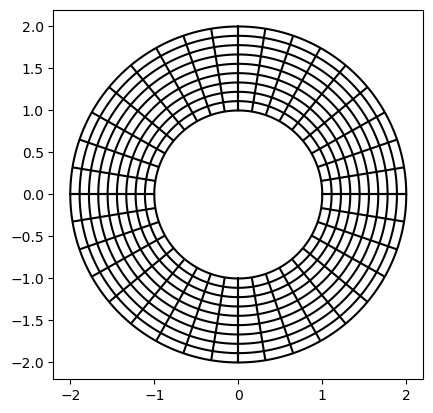

In [4]:
for g in geos:
    vis.plot_geo(g)
axis('scaled');

In [5]:
class multipatch_block_handler:
    
    # Takes array of multi-patch objects
    def __init__( self, multi_patches ):
        self.multi_patches = multi_patches
        self.numpatches = multi_patches[0].numpatches
        for multi_patch in multi_patches:
            if multi_patch.numpatches != self.numpatches:
                print("Inconsistent numbers of patches")

    def patch_to_global(self, p):
        first = True
        for multi_patch in self.multi_patches:
            if first:
                X = multi_patch.patch_to_global(p)
                first = False
            else:
                X = scipy.sparse.block_diag((X,multi_patch.patch_to_global(p)))
        return X
    
    def compute_dirichlet_bcs(self, data):
        first = True
        p = 0
        offset = 0
        for multi_patch in self.multi_patches:
            data_p = []
            for item in data:
                if len(item)<4 or p in item[3]:
                    data_p.append( (item[0], item[1], lambda *x : item[2](*x)[p]) )
            if len(data_p)>0:
                bcs_p = multi_patch.compute_dirichlet_bcs(data_p)
                if first:
                    bcs = list(bcs_p)
                    first = False
                else:
                    #Indices need offset
                    bcs[0] = numpy.concatenate((bcs[0],bcs_p[0]+offset))
                    #Values are kept as-is
                    bcs[1] = numpy.concatenate((bcs[1],bcs_p[1]))
            offset += multi_patch.numdofs
            p += 1
        return tuple(bcs)
    
    def compute_local_offset_for_component(self, p, c):
        offset = 0
        for cc in range(c):
            dim = 1
            kvs, geo = self.multi_patches[cc].patches[p]
            for kv in kvs:
                dim *= kv.numdofs
            offset += dim
        return offset
    

In [6]:
# source term f 
def f(x, y): return (0.0, 0.0)

# rubber, Lamé-coeff.
Mu = 0.003 # [GPa]
Lam = 0.00028416 #  [GPa] (under ass. ny=0.48, almost incompressible)

# Bilinear form
def linelast_vf(dim):
    from pyiga.vform import VForm, grad, inner, div, dx
    vf = VForm(dim)
    u, v = vf.basisfuns(components=(dim,dim)) # vector valued
    e_u = 1/2 * (grad(u) + grad(u).T)
    e_v =  1/2 * (grad(v) + grad(v).T)
    vf.add(2* Mu *inner(e_u, e_v) * dx) 
    return vf

#Neumann BC
def gN(x, y): return (1.5e-4, -1.5e-4) 

neu_data = [
    (3,'right',gN) 
]

# Multipatch objects for all variables
MP_block = multipatch_block_handler( [MP_u, MP_u, MP_p] )

In [16]:
first = True
for p in range(MP_block.numpatches):
    X = MP_block.patch_to_global(p)
    
    # All the geometries are supposed to be equal; also kvs_ux and kvs_uy are equal
    kvs_ux, geo_ux = MP_block.multi_patches[0].patches[p]
    #kvs_uy, geo_uy = MP_block.multi_patches[1].patches[p]
    kvs_p, geo_p = MP_block.multi_patches[2].patches[p]
    
    # The whole patch-local stiffness matrix
    A_grad = assemble.assemble_vf(linelast_vf(2), kvs_ux, geo=geo_ux, symmetric=True)    
    A_div  = assemble.assemble('div(u) * p * dx', (kvs_ux, kvs_p), bfuns=[('u',2,0), ('p',1,1)], geo=geo_ux)
    A_0  = assemble.assemble('p * q * dx', kvs_p, bfuns=[('p',1,0), ('q',1,0)], geo=geo_ux)

    A_p = scipy.sparse.bmat(
        [[A_grad, A_div.T],
         [A_div,  -A_0/Lam]], format='csr')
    
    
    # The patch-local right-hand side
    b_p = assemble.inner_products(kvs_ux, f, f_physical=True, geo=geo_ux).ravel()
    b_p = np.resize(b_p, shape(A_p)[0])
    
    # The patch-local Neumann boundary data
    for item in neu_data:
        if item[0]==p:
            N_e   = assemble.assemble('inner(g,v)*ds', kvs_ux, bfuns=[('v',2)], geo=geo_ux, g=item[2], boundary=item[1])
            bdofs = assemble.boundary_dofs(kvs_ux, item[1], ravel=True)
            for c in range(2):
                offset = MP_block.compute_local_offset_for_component(p,c)
                for i in range(len(bdofs)):
                    b_p[bdofs[i]+offset] += N_e[c,i,0]
    
    if first:
        A = X @ A_p @ X.T
        b = X @ b_p
        first = False
    else:
        A += X @ A_p @ X.T
        b += X @ b_p

print(shape(A))
print(shape(b))

(20224, 20224)
(20224,)


In [8]:
# define Dirichlet boundary conditions 
# Dirichlet boundary function g
def g_zero(x, y): return (0.0, 0.0)

# set up Dirichlet boundary conditions
bc = MP_block.compute_dirichlet_bcs([
    (1, 'right', g_zero, [0,1] )
])


In [9]:
# set up and solve linear system
LS = assemble.RestrictedLinearSystem(A, b, bc)
u_sol = solvers.make_solver(LS.A, spd=False).dot(LS.b)
u = LS.complete(u_sol)

#print(shape(u))
print(u)


[ 4.47313635e-02  4.47323988e-02  4.47787496e-02 ... -1.58920169e-05
 -1.70913859e-05 -2.73781461e-05]


In [10]:
#print(MP.numdofs) # global dofs (=all dofs interface dofs,i.e. 2x16-4 = 28)
#print(2*MP.numdofs) 

u1 = u[:MP_u.numdofs] 
u2 = u[MP_u.numdofs:2*MP_u.numdofs]

In [11]:
# restrict solution to each individual patch
u1_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u1)
           for p in range(len(patches_u))]
u2_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u2)
           for p in range(len(patches_u))]

In [12]:
ref= 10
# evaluate displacement and "pressure" over a grid in the parameter domain
xgrid = linspace(0, 1, ref)
xygrid = (xgrid, xgrid)

(-2.2024363165789773,
 2.0487263315795428,
 -2.0487263315754047,
 2.2024363165787704)

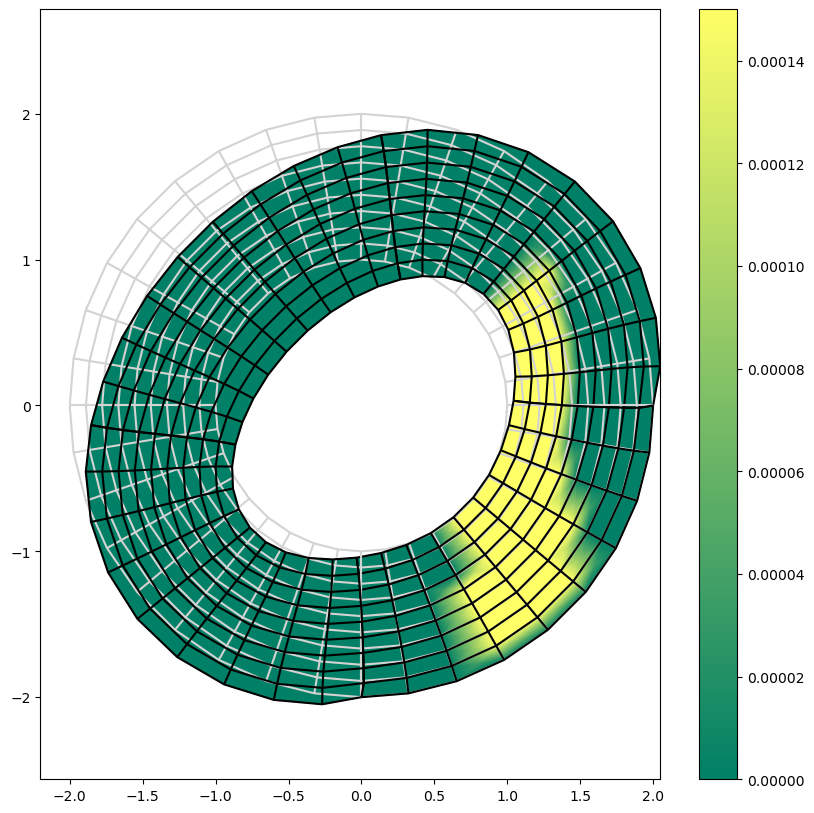

In [13]:
## nbc in parameter domain

figsize(10,10)
fig, ax = plt.subplots()
k=0
d=[]
len_xgrid= len(xgrid)
#dis=np.empty([4,len_xgrid,2])

for (u1_func, u2_func, (kvs, geo)) in zip(u1_funcs, u2_funcs, patches_u): #u_funcs 
        
    #print(k)
    dis1 = u1_func.grid_eval(xygrid) #x-value
    dis2 = u2_func.grid_eval(xygrid) #y-value
    #print('dis1= ', dis1)
    #print([dis1,dis2])
    dis = np.stack((dis1,dis2), axis=-1)
    #print('dis=', dis)
    #d.append(dis)
    k+=1
    
    vis.plot_deformation(dis, ref, geo, ax, vmin=0.0, vmax=1.5e-4)


colorbar();
axis('equal')